# spinal_hyperparametersB.ipynb
Search for hyperparameters that lead to good reaching for the model in spinal_test6.

This notebook is based on the ["Using SMAC in Python:SVM"](https://automl.github.io/SMAC3/master/quickstart.html#using-smac-in-python-svm)  example of the SMAC documentation. Modifications were made to the original `spinal_hyperparameters` in order to use the PSMAC module.

## 1) Importing modules

In [1]:
# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.configspace import Configuration
from smac.scenario.scenario import Scenario
from smac.facade.smac_facade import SMAC
from smac.facade.psmac_facade import PSMAC

/usr/local/lib/python3.7/site-packages/pyparsing.py:2725: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


In [2]:
%cd ../..

#from psmac_facade_soup import PSMAC
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time

/Users/sergio/projects/draculab


## 2) Describing all hyperparameters (configuration space)

In [3]:
# Build Configuration Space which defines all parameters and their ranges
cs = ConfigurationSpace()

# plant
p1 = CategoricalHyperparameter("p1", [(-0.01, 0.05), (0.0, 0.04)], default_value=(0.0, 0.04))
p5 = CategoricalHyperparameter("p5", [(0.01, -0.05), (0.0, -0.04)], default_value=(0.0, -0.04))
mu = UniformFloatHyperparameter("mu", 0.1, 4.0, default_value=0.5) # for both mu1 and mu2
m_gain = UniformFloatHyperparameter("m_gain", 5., 100., default_value=30.)
# units
M_des_out_w_abs_sum = UniformFloatHyperparameter("M_des_out_w_abs_sum", 0.5, 4., default_value=1.)
CE_thresh = UniformFloatHyperparameter("CE_thresh", -0.1, 1., default_value=0.2)
CE_slope =  UniformFloatHyperparameter("CE_slope", 1., 4., default_value=2.)
CE_integ_amp =  UniformFloatHyperparameter("CE_integ_amp", 0., 3., default_value=.5)
CE_adapt_amp =  UniformFloatHyperparameter("CE_adapt_amp", 2., 12., default_value=8.)
CE_des_out_w_abs_sum =  UniformFloatHyperparameter("CE_des_out_w_abs_sum", 0.5, 4., default_value=1.)
CI_thresh = UniformFloatHyperparameter("CI_thresh", 0., 2., default_value=0.5)
CI_slope =  UniformFloatHyperparameter("CI_slope", 1., 4., default_value=2.)
CI_integ_amp =  UniformFloatHyperparameter("CI_integ_amp", 0., 3., default_value=.5)
CI_adapt_amp =  UniformFloatHyperparameter("CI_adapt_amp", 2., 12., default_value=8.)
CI_des_out_w_abs_sum =  UniformFloatHyperparameter("CI_des_out_w_abs_sum", 0.5, 4., default_value=1.)
AL_thresh =  UniformFloatHyperparameter("AL_thresh", 0., 1.5, default_value=.3)
AL_slope =  UniformFloatHyperparameter("AL_slope", 0.5, 4., default_value=2.)
# connections
M__CE_lrate =  UniformFloatHyperparameter("M__CE_lrate", 1., 200., default_value=100.)
M__CE_w_sum =  UniformFloatHyperparameter("M__CE_w_sum", .5, 4., default_value=2.)
M__CI_lrate =  UniformFloatHyperparameter("M__CI_lrate", 1., 200., default_value=100.)
M__CI_w_sum =  UniformFloatHyperparameter("M__CI_w_sum", .5, 4., default_value=2.)
AF__M_extra_steps = UniformIntegerHyperparameter("AF__M_extra_steps", 1, 30, default_value=16) # also set AF_params['delay'] accordingly
AF__M_w_sum = UniformFloatHyperparameter("AF__M_w_sum", .5, 8., default_value=3.)
AF__M_lrate = UniformFloatHyperparameter("AF__M_lrate", .5, 8., default_value=3.)
CE__CI_init_w = UniformFloatHyperparameter("CE__CI_init_w", .1, 15., default_value=1., log=True)
CI__CE_init_w = UniformFloatHyperparameter("CI__CE_init_w", -2.5, -.2, default_value=-1.5)
C__C_antag_type = CategoricalHyperparameter("C__C_antag_type", ['bcm', 'oja', 'sq_hebbsnorm', 'static'], default_value='bcm')
C__C_antag_lrate = UniformFloatHyperparameter("C__C_antag_lrate", .01, 20., default_value=1., log=True)
C__C_antag_omega = UniformFloatHyperparameter("C__C_antag_omega", 0.5, 5., default_value=3.) # use half for p_antag?
rga_delay = UniformFloatHyperparameter("rga_delay", 0., .8, default_value=.225) # get del_steps from here

cs.add_hyperparameters([p1, p5, mu, m_gain, M_des_out_w_abs_sum,
                        CE_thresh, CE_slope, CE_integ_amp, CE_adapt_amp, CE_des_out_w_abs_sum,
                        CI_thresh, CI_slope, CI_integ_amp, CI_adapt_amp, CI_des_out_w_abs_sum, 
                        AL_thresh, AL_slope, M__CE_lrate, M__CE_w_sum, M__CI_lrate, M__CI_w_sum,
                        AF__M_extra_steps, AF__M_w_sum,  AF__M_lrate, CE__CI_init_w, CI__CE_init_w,
                        C__C_antag_type, C__C_antag_lrate, C__C_antag_omega, rga_delay])
use_omega = InCondition(child=C__C_antag_omega, parent=C__C_antag_type, values=['sq_hebbsnorm'])
use_antag_lrate = InCondition(child=C__C_antag_lrate, parent=C__C_antag_type, 
                              values=['sq_hebbsnorm', 'bcm', 'oja'])
cs.add_conditions([use_omega, use_antag_lrate])

[C__C_antag_omega | C__C_antag_type in {'sq_hebbsnorm'},
 C__C_antag_lrate | C__C_antag_type in {'sq_hebbsnorm', 'bcm', 'oja'}]

## 3) An auxiliary function that creates a draculab network from a configuration dictionary

In [4]:
def net_from_cfg(cfg):
    """ Create a draculab network with the given configuration. 
    
        Args:
            cfg : a parameter dictionary with the configuration space from step 2.
        
        Returns:
            net, pops_dict
            net : A draculab network as in spinal_test6, with the given configuration.
            pops_dict : a dictionary with the list of ID's for each population in net.
    """
    print(type(cfg))
    print(cfg)
    par_heter = 0.05 # range of heterogeneity as a fraction of the original value
    t_pres = 50. # number of seconds to hold each set of target lengths
    rand_init_w = True # whether to use random initial connections
    
    net_params = {'min_delay' : 0.005,
                  'min_buff_size' : 10 }
    P_params = {'type' : plant_models.bouncy_planar_arm,
                'mass1' : 0.9,
                'mass2' : 0.7,
                'smin' : -0.4,
                'p1' : cfg['p1'],
                'p3' : (0., 0.05),
                'p5' : cfg['p5'],
                'init_q1' : np.pi/4., #0.53496133, 
                'init_q2' : np.pi/2., #0.89566479, 
                'init_q1p' : 0.,
                'init_q2p' : 0.,
                'g' : 0.,
                'mu1' : cfg['mu'],
                'mu2' : cfg['mu'],
                'l_torque' : 0.01,
                'l_visco' : 0.05,
                'm_gain' : cfg['m_gain'],
                'l_gain' : 1.,
                'v_gain' : 5.,
                'spring' : 1.,
                'tau' : 0.1 }
    
    net = network(net_params)
    P = net.create(1, P_params)
    arm = net.plants[P]

    # We organize the spinal connections through 4 types of symmetric relations
    # these lists are used to set intraspinal connections and test connection matrices
    antagonists = [(0,3), (1,2), (4,5)]
    part_antag = [(0,2),(0,5), (3,4), (1,3)]
    synergists = [(0,1), (0,4), (2,3), (3,5)]
    part_syne = [(1,4), (2,5)]
    self_conn = [(x,x) for x in range(6)]

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # UNIT PARAMETER DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
    randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))

    SF_params = {'type' : unit_types.sigmoidal,
                 'thresh' : 1.3 * randz6(),
                 'slope' : 2.5 * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.03 * randz6() } 
    SP_params = {'type' : unit_types.source,
                 'init_val' : 0.5,
                 'tau_fast' : 0.02,
                 'tau_mid' : 0.1,
                 'function' : lambda t: None }
    SP_CHG_params = {'type' : unit_types.sigmoidal,
                  'thresh' : 0.3,
                  'slope' : 9.,
                  'init_val' : 0.1,
                  'tau' : 0.01 }
    SPF_params = {'type' : unit_types.sigmoidal,
                  'thresh' : 0.4 * randz6(),
                  'slope' : 6. * randz6(),
                  'init_val' : 0.3 * randz6(),
                  'tau_fast': 0.005,
                  'tau_mid': 0.05,
                  'tau_slow' : 5.,
                  'tau' : 0.02 * randz6() }
    M_params = {'type' : unit_types.gated_out_norm_am_sig,
                'thresh' : 0. * randz6(),
                'slope' : 3. * randz6(),
                'init_val' : 0.2 * randz6(),
                'delay' : 0.2,
                'tau_fast': 0.01,
                'tau_mid': 0.05,
                'tau_slow' : 2.,
                'tau' : 0.01 * randz6(),
                'des_out_w_abs_sum' : cfg['M_des_out_w_abs_sum'] }
    CE_params = {'type' : unit_types.gated_rga_adapt_sig,
                 'thresh' : cfg['CE_thresh'] * randz6(),
                 'slope' : cfg['CE_slope'] * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.02 * randz6(),
                 'tau_fast': 0.01,
                 'tau_mid' : 0.05,
                 'tau_slow' : 6.,
                 'custom_inp_del' : 15,
                 'integ_amp' : cfg['CE_integ_amp'],
                 'adapt_amp' : cfg['CE_adapt_amp'],
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : cfg['CE_des_out_w_abs_sum'] }
    CI_params = {'type' : unit_types.gated_rga_adapt_sig,
                 'thresh' : cfg['CI_thresh'] * randz6(),
                 'slope' : cfg['CI_slope'] * randz6(),
                 'init_val' : 0.2 * randz6(),
                 'tau' : 0.5 * randz6(),
                 'tau_fast': 0.01,
                 'tau_mid' : 0.05,
                 'tau_slow' : 6.,
                 'custom_inp_del' : 15,
                 'integ_amp' : cfg['CI_integ_amp'],
                 'adapt_amp' : cfg['CI_adapt_amp'],
                 'delay' : 0.2,
                 'des_out_w_abs_sum' : cfg['CI_des_out_w_abs_sum'] }
    AL_params = {'type' : unit_types.sigmoidal,
                 'thresh' : cfg['AL_thresh'] * randz6(),
                 'slope' : cfg['AL_slope'] * randz6(),
                 'init_val' : 0.1 * randz6(),
                 'tau' : 0.02 * randz6() }
    AF_params = {'type' : unit_types.logarithmic,
                 'init_val' : 0.5 * randz18(),
                 'tau' : 0.02 * randz18(),
                 'tau_fast': 0.005,
                 'delay' : 0.1,
                 'thresh' : [-.9, -0.5, 0.5,
                             -1.1, -0.5, 0.5,
                             -.8, -0.5, 0.5,
                             -.8, -0.5, 0.5,
                             -.8, -0.5, 0.5,
                             -1.4, -0.5, 0.5] } # length afferents report (l-l0)/l0
    ACT_params = {'type' : unit_types.act,
                  'tau_u' : 7.,
                  'gamma' : 2.,
                  'g' : 3.,
                  'theta' : 1.4,
                  'tau_slow' : 5.,
                  'y_min' : 0.4,
                  'rst_thr' : 0.3,
                  'init_val' : 0. }
    spf_sum_min = .4 # value where no corrections are needed anymore
    y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
    ACT_params['y_min'] = y_min

    track_params = {'type' : unit_types.source,
                    'init_val' : 0.02,
                    'function' : lambda t: None }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTION DICTIONARIES
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # SF, SP to SPF
    SFe__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.01 }
    SFi__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SFe__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : 1. }
    SFi__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : -1. }
    SPe__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.01 }
    SPi__SPF_conn = {'rule' : "one_to_one",
                     'delay' : 0.02 }
    SPe__SPF_syn = {'type' : synapse_types.static,
                    'init_w' : 1. }
    SPi__SPF_syn = {'type' : synapse_types.static,
                   'init_w' : -1. }
    # SP to SP_CHG
    SP__SP_CHG_conn = {'rule' : 'all_to_all',
                        'delay' : 0.01}
    SP__SP_CHG_syn = {'type' : synapse_types.chg,
                      'init_w' : 0.,
                      'lrate' : 20. }
    # SP_CHG to CE, CI
    SP_CHG__CE_conn = {'rule' : "all_to_all",
                      'delay' : 0.02 }
    SP_CHG__CE_syn = {'type' : synapse_types.static,
                      'inp_ports' : 2,
                      'init_w' : 1. }
    SP_CHG__CI_conn = {'rule' : "all_to_all",
                       'delay' : 0.02 }
    SP_CHG__CI_syn = {'type' : synapse_types.static,
                      'inp_ports' : 2,
                      'init_w' : 1. }
    # SP_CHG to ACT
    SP_CHG__ACT_conn = {'rule' : "all_to_all",
                       'delay' : 0.02 }
    SP_CHG__ACT_syn = {'type' : synapse_types.static,
                      'inp_ports' : 1,
                      'init_w' : 1. }
    # SP_CHG to M
    SP_CHG__M_conn = {'rule' : "all_to_all",
                      'delay' : 0.02 }
    SP_CHG__M_syn = {'type' : synapse_types.static,
                      'inp_ports' : 2,
                      'init_w' : 1. }
    # SPF to M
    SPF__M_conn = {'rule': 'one_to_one',
                   'delay': 0.01 }
    SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
                  'inp_ports' : 1,
                  'lrate' : 0.,
                  'input_type' : 'error', # if using inp_corr
                  'init_w' : 2. }
    # SPF to ACT
    SPF__ACT_conn = {'rule' : "all_to_all",
                     'delay' : 0.02 }
    SPF__ACT_syn = {'type' : synapse_types.static,
                    'inp_ports' : 0,
                    'init_w' : 1. }
    # ACT to CE,CI
    ACT__CE_conn = {'rule' : "all_to_all",
                    'delay' : 0.02 } 
    ACT__CE_syn = {'type' : synapse_types.static,
                   'inp_ports' : 3,
                   'init_w' : 1. }
    ACT__CI_conn = {'rule' : "all_to_all",
                    'delay' : 0.02 } 
    ACT__CI_syn = {'type' : synapse_types.static,
                   'inp_ports' : 3,
                   'init_w' : 1. }
    # motor to spinal connections
    # creating a test matrix
    if not rand_init_w:
        M_CE = np.zeros((6, 6))
        M_CI = np.zeros((6, 6))
        for x in range(6):
            M_CI[x,x] = 1.
            for pair in antagonists:
                if x == pair[0]:
                    M_CE[x, pair[1]] = 1.
                    M_CE[pair[1], x] = 1.
            for pair in part_antag:
                if x == pair[0]:
                    M_CE[x, pair[1]] = 0.4
                    M_CE[pair[1], x] = 0.4
            for pair in synergists:
                if x == pair[0]:
                    M_CI[x, pair[1]] = 0.5
                    M_CI[pair[1], x] = 0.5
            for pair in part_syne:
                if x == pair[0]:
                    M_CI[x, pair[1]] = 0.3
                    M_CI[pair[1], x] = 0.3
    if rand_init_w:
        M_CE = 0.4*(np.random.random((6,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
        M_CI = 0.4*(np.random.random((6,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
    M__CE_conn = {'rule': 'all_to_all',
                 'delay': 0.02 }
    M__CE_syn = {'type' : synapse_types.gated_rga,
                 'inp_ports' : 0,
                 'lrate' : cfg['M__CE_lrate'],
                 'w_sum' : cfg['M__CE_w_sum'],
                 'init_w' : M_CE.flatten() }
    M__CI_conn = {'rule': 'all_to_all',
                 'delay': 0.02 }
    M__CI_syn = {'type' : synapse_types.gated_rga,
                 'inp_ports' : 0,
                 'lrate' : cfg['M__CI_lrate'],
                 'w_sum' : cfg['M__CI_w_sum'],
                 'init_w' : M_CI.flatten() }
    # interneurons to alpha motoneurons
    CE__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__AL_syn = {'type' : synapse_types.static,
                  'init_w' : [1., 1., 1., 1., 1., 1.3] }
    CI__AL_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__AL_syn = {'type' : synapse_types.static,
                  'init_w' : -1. }
    # alpha motoneurons to plant
    AL__P_conn = {'inp_ports' : list(range(0,18,3)),
                 'delays': 0.01 }
    AL__P_syn = {'type': synapse_types.static,
                'init_w' : [1., 1., 1.7, 1.2, 1., 2.5] } #1.5 }
    # length afferents to sensory
    AF__SF_conn = {'rule' : 'one_to_one',
                  'delay' : 0.02 }
    AF__SF_syn = {'type' : synapse_types.static,
                 'init_w' : [2.5, 2., 2.2, 2.5, 2.1, 2.1] }
    # afferents to motor
    ## Creating a test matrix
    AF_M = np.zeros((6, 18))
    def a_m_connect(A_M, pair_list, weights):
        for pair in pair_list:
            A_M[pair[0], 3*pair[1]] = weights[0]
            A_M[pair[0], 3*pair[1]+1] = weights[1]
            A_M[pair[0], 3*pair[1]+2] = weights[2]
            A_M[pair[1], 3*pair[0]] = weights[0]
            A_M[pair[1], 3*pair[0]+1] = weights[1]
            A_M[pair[1], 3*pair[0]+2] = weights[2]        
    a_m_connect(AF_M, self_conn, (0., -0.4, 0.4))
    a_m_connect(AF_M, synergists, (0., -0.2, 0.2))
    a_m_connect(AF_M, part_syne, (0., 0., 0.))
    a_m_connect(AF_M, part_antag, (0., 0.2, -0.2))
    a_m_connect(AF_M, antagonists, (0., 0.4, -0.4))
    AF_M = AF_M.transpose()
    if rand_init_w:
        AF_M = 0.2*(np.random.random((18,6)) - 0.5) # random initial connections!!!!!!!!!!!!!!!!!!!
    #f = 1. # going estimate the extra delay of error inputs wrt afferent inputs at M
    #w = 2.*np.pi*f
    #sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
    #spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
    #delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
    #steps = int(round(delay/net.min_delay))
    steps = cfg['AF__M_extra_steps']
    delay = net_params['min_delay'] * (steps + 1)
    AF_params['delay'] = AF_params['delay'] + delay + net_params['min_delay']
    AF__M_conn = {'rule' : 'all_to_all',
                 'delay' : 0.02 }
    AF__M_syn = {'type' : synapse_types.gated_inp_sel, #synapse_types.inp_corr,
                'aff_port' : 0,
                'error_port' : 1,
                'w_sum' : cfg['AF__M_w_sum'],
                'inp_ports' : 0, # afferent for out_norm_am_sig
                'input_type' : 'pred', # if using inp_corr
                'lrate' : cfg['AF__M_lrate'],
                'extra_steps' : steps,
                'init_w' : AF_M.flatten() }
    # plant to afferents
    bool_aff = [False] * 4 + [False, True, True, True] * 6
    idx_aff = np.arange(28)[bool_aff] # indexes for afferent output in the arm
    P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
                 'delays' : 0.02 }
    P__AF_syn = {'type' : synapse_types.static,
                'init_w' : [3.5, 3., .7]*6 }
    # lateral connections in C
    CE__CI_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CI__CE_conn = {'rule' : 'one_to_one',
                   'delay' : 0.01 }
    CE__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : cfg['CE__CI_init_w'] }
    CI__CE_syn = {'type' : synapse_types.static, #corr_inh,
                  'inp_ports' : 1,
                  'lrate' : .0,
                  'des_act' : 0.5,
                  'init_w' : cfg['CI__CE_init_w'] }
    C__C_conn = {'rule': 'one_to_one',
                 'allow_autapses' : False,
                 'delay' : 0.015 }
    omega = 3.
    if cfg['C__C_antag_type'] != 'static': 
        antag_lrate = 0.
    else:
        antag_lrate = ['C__C_antag_lrate']
    if cfg['C__C_antag_type'] == 'bcm': 
        antag_type = synapse_types.bcm
    elif cfg['C__C_antag_type'] == 'oja': 
        antag_type = synapse_types.oja
    elif cfg['C__C_antag_type'] == 'static': 
        antag_type = synapse_types.static
        antag_lrate = 0.
    elif cfg['C__C_antag_type'] == 'sq_hebbsnorm': 
        antag_type = synapse_types.sq_hebbsnorm
        omega = cfg['C__C_antag_omega']
            
    C__C_syn_antag = {'type' : antag_type,
                      'inp_ports': 1,
                      'init_w' : 1.,
                      'lrate' : antag_lrate,
                      'omega' : omega,
                      'des_act' : 0.5 }
    C__C_syn_p_antag = {'type' : antag_type,
                      'inp_ports': 1,
                      'init_w' : .4,
                      'lrate' : antag_lrate,
                      'omega' : 0.5*omega,
                      'des_act' : 0.5 }
    C__C_syn_syne = {'type' : synapse_types.static,
                     'inp_ports': 1,
                     'lrate' : 1.,
                     'init_w' : 1. }
    C__C_syn_p_syne = {'type' : synapse_types.static,
                       'inp_ports': 1,
                       'lrate' : 1.,
                       'init_w' : 0.4 }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CREATING UNITS
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    SF = net.create(6, SF_params)
    SP = net.create(6, SP_params)
    SPF = net.create(6, SPF_params)
    AL = net.create(6, AL_params)
    AF = net.create(18, AF_params)
    SP_CHG = net.create(1, SP_CHG_params)
    # Approximating the delays for the rga rule
    del_steps = int(np.ceil(cfg['rga_delay']/net_params['min_delay']))
    time_del = (del_steps + 1)*net_params['min_delay']
    CE_params['delay'] = time_del
    CI_params['delay'] = time_del
    M_params['delay'] = time_del
    CE_params['custom_inp_del'] = del_steps
    CI_params['custom_inp_del'] = del_steps
    CE = net.create(6, CE_params)
    CI = net.create(6, CI_params)
    M = net.create(6, M_params)
    ACT = net.create(1, ACT_params)

    # SET THE PATTERNS IN SP
    # list with hand coordinates [x,y] (meters)
    hand_coords = [[0.3, 0.45], 
                   [0.35, 0.4],
                   [0.4, 0.35],
                   [0.35, 0.3],
                   [0.3, 0.25],
                   [0.25, 0.3],
                   [0.2, 0.35],
                   [0.25, 0.4]]
    # list with muscle lengths corresponding to the hand coordinates
    m_lengths = []
    for coord in hand_coords:
        m_lengths.append(arm.coords_to_lengths(coord))
    m_lengths = np.array(m_lengths)
    # We need to translate these lengths to corresponding SF activity levels.
    # For that it is necessary to recreate all their transformations
    # The first transformation is from length to Ia activity in the muscle object
    l = np.array([net.plants[P].muscles[i].l0 for i in range(6)]) # resting lengths
    m_lengths = P_params['l_gain']*(m_lengths - l) / l
    # Next transformation is through the logarithmic afferent units
    l_arg = (P__AF_syn['init_w'][0]*m_lengths) - np.array(AF_params['thresh'][0:16:3])
    l_affs = np.log(1. + np.maximum(0., l_arg))
    # Next is from AF to SF
    sf_arg = AF__SF_syn['init_w']*l_affs
    sf_preds = 1./ (1. + np.exp(-np.mean(SF_params['slope'])*(sf_arg - np.mean(SF_params['thresh']))))

    m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths
    #m_idxs[0] = 0 # for testing

    def make_fun(idx):
        """ create a function for the SP unit with index 'idx'. """
        return lambda t: sf_preds[m_idxs[int(np.floor(t/t_pres))]][idx]

    for idx, u in enumerate(SP):
        net.units[u].set_function(make_fun(idx))

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # CONNECTING
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # from M to CE
    net.connect(M, CE, M__CE_conn, M__CE_syn)
    # from M to CI
    net.connect(M, CI, M__CI_conn, M__CI_syn)
    # from CE to AL
    net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
    # from CI to AL
    net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
    # from AL to P
    net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
    # from P to AF
    net.set_plant_outputs(P, AF, P__AF_conn, P__AF_syn)
    # from AF to SF. Only the length afferents are selected
    AF_len = [AF[i] for i in range(0,18,3)]
    net.connect(AF_len, SF, AF__SF_conn, AF__SF_syn)
    # from AF to M
    net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
    # from SF, SP to SPF
    #net.connect(SF, SPF[0:6], SFe__SPF_conn, SFe__SPF_syn)
    net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn) 
    #net.connect(SP, SPF[0:6], SPi__SPF_conn, SPi__SPF_syn)
    net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)
    # from SPF to M
    net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after A-->M
    # from SPF to ACT
    net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
    # from CE to CI, and CI to CE
    net.connect(CE, CI, CE__CI_conn, CE__CI_syn)
    net.connect(CI, CE, CI__CE_conn, CI__CE_syn)
    # from SP to SP_CHG
    net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
    # from SP_CHG to CE,CI
    net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
    net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
    # from SP_CHG to M
    net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
    # from SP_CHG to ACT
    net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
    # from ACT to CE, CI
    net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
    net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
    # intraspinal connections 
    EE_syn_dicts = [C__C_syn_syne, C__C_syn_p_syne]
    EI_syn_dicts = [C__C_syn_antag, C__C_syn_p_antag]
    EE_pair_lists = [synergists, part_syne] # order should match list above
    EI_pair_lists = [antagonists, part_antag] # order should match list above
    for pair_list, syn_dict in zip(EE_pair_lists, EE_syn_dicts):
        firsts = [CE[p[0]] for p in pair_list]
        seconds = [CE[p[1]] for p in pair_list]
        net.connect(firsts, seconds, C__C_conn, syn_dict)
        net.connect(seconds, firsts, C__C_conn, syn_dict)
    for pair_list, syn_dict in zip(EI_pair_lists, EI_syn_dicts):
        firsts = [CE[p[0]] for p in pair_list] + [CE[p[1]] for p in pair_list]
        seconds = [CI[p[1]] for p in pair_list] + [CI[p[0]] for p in pair_list]
        net.connect(firsts, seconds, C__C_conn, syn_dict)

    pops_list = [SF, SP, SPF, AL, AF, SP_CHG, CE, CI, M, ACT]
    pops_names = ['SF', 'SP', 'SPF', 'AL', 'AF', 'SP_CHG', 'CE', 'CI', 'M', 'ACT']
    pops_dict = {pops_names[idx] : pops_list[idx] for idx in range(len(pops_names))}
    return net, pops_dict

## 4) A function that evaluates the quality of a given configuration

In [5]:
def eval_config(cfg):
    """ Returns the error for a network with a given configuration.
    
        Args:
            cfg : a configuration dictionary. ##sampled from a ConfigurationSpace object.
        Returns:
            error : A float calculated from the sum of activities in the SPF layer.
    """
    # convert cfg into a dictionary
    #cfg = {k : cfg[k] for k in cfg if cfg[k]}
    
    # obtain a network with the given configuration
    net, pops_dict = net_from_cfg(cfg)
    
    # run the network
    run_time = 5.
    start_time = time.time()
    times, data, plant_data  = net.flat_run(run_time)
    print('Execution time is %s seconds' % (time.time() - start_time))
    SPF = pops_dict['SPF']
    SPF_data = np.array([data[i] for i in SPF])
    n_u, n_pts = SPF_data.shape
    
    # sum of squared SPF values
    SPF_sum = np.linalg.norm(SPF_data[:, n_pts//2:] - 0.083)
    # TODO: calculate that 0.083 here
    # 1./(1. + np.exp(6.*(0.4)))
    
    return SPF_sum

## 5) The scenario object

In [6]:
scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternatively runtime)
                     "runcount-limit": 5,   # maximum function evaluations
                     "cs": cs,               # configuration space
                     "deterministic": "false",
                     "shared_model": True,
                     "ta" : eval_config,
                     #"input_psmac_dirs": "/Users/sergio/projects/draculab/smac",
                     "input_psmac_dirs": "smac3_out"
                     })

## 6) Optimize with the PSMAC object

In [9]:
# Optimize, using a PSMAC object
print("Attempting PSMAC optimization.")
    
psmac = PSMAC(scenario=scenario, rng=np.random.RandomState(42),
              tae=ExecuteTAFuncDict, n_optimizers=2, validate=False)

incumbent = psmac.optimize()

#inc_value = eval_config(incumbent)
inc_value = 0.

print("Optimized Value: %.2f" % (inc_value))

Attempting PSMAC optimization.


Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/sergio/Library/Python/3.7/lib/python/site-packages/smac/facade/psmac_facade.py", line 60, in optimize
    solver = SMAC(scenario=scenario, tae_runner=tae, rng=rng, **kwargs)
  File "/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/

Optimized Value: 0.00


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
# this is the error happening in the _parse_argument method of
# https://automl.github.io/SMAC3/master/_modules/smac/utils/io/output_writer.html#OutputWriter.write_scenario_file


" ".join(eval_config)

# if you can just skip the part where they try to write the "ta" value this might work.
# curiously, 
# scenario.write()
# does work if executed before the cell above

TypeError: can only join an iterable

In [7]:
scenario.write()

In [8]:
scenario.output_dir

'smac3-output_2019-08-06_01:14:42_211566'

In [10]:
scenario.output_dir

'psmac3-output_2019-08-06_01:15:07_193262'

In [ ]:
# Optimize, using a few SMAC objects
from multiprocessing import Pool
n_procs = 3
print("Attempting parallel optimization with %d workers" % (n_procs))

smacs = [SMAC(scenario=scenario, rng=np.random.RandomState(i),
         tae_runner=eval_config) for i in range(n_procs)]
def runner(smac_idx):
    return smacs[smac_idx].optimize()

def runner2(seed):
    smac = SMAC(scenario=scenario, rng=np.random.RandomState(seed),
                tae_runner=eval_config)
    return smac.optimize()

with Pool(processes=n_procs) as pool:
    incumbents = pool.imap_unordered(runner2, range(n_procs))
    #incumbents = [pool.apply_async(runner, i) for i in range(n_procs)]
    #inc_values = [res.get() for res in incumbents]
    #pool.join()
    #pool.close()

inc_values = [eval_config(inc) for inc in incumbents]

#print("Optimized Value: %.2f" % (inc_value))
print(inc_values)

Attempting parallel optimization with 3 workers


### quick test

In [9]:
# a quick test
# get default parameter dictionary
#hyperparams = cs.get_all_unconditional_hyperparameters() + [par for par in cs.get_all_conditional_hyperparameters()]

#defaults = cs.get_default_configuration()
#def_dict = {k : defaults[k] for k in defaults if defaults[k]}

inc_dict = {k : incumbent[k] for k in incumbent if incumbent[k]}

# run network built from default/incumbent dictionary
net, pops_dict = net_from_cfg(inc_dict)
start_time = time.time()
times, data, plant_data  = net.flat_run(1000.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 2828.8006110191345 seconds


[0.56608727 0.42430383 0.020512   0.02496532 0.37514506 0.04905569]
[0.74310271 0.0738587  0.03106703 0.03827752 0.4343715  0.02398465]


Text(0.5, 1.0, 'C')

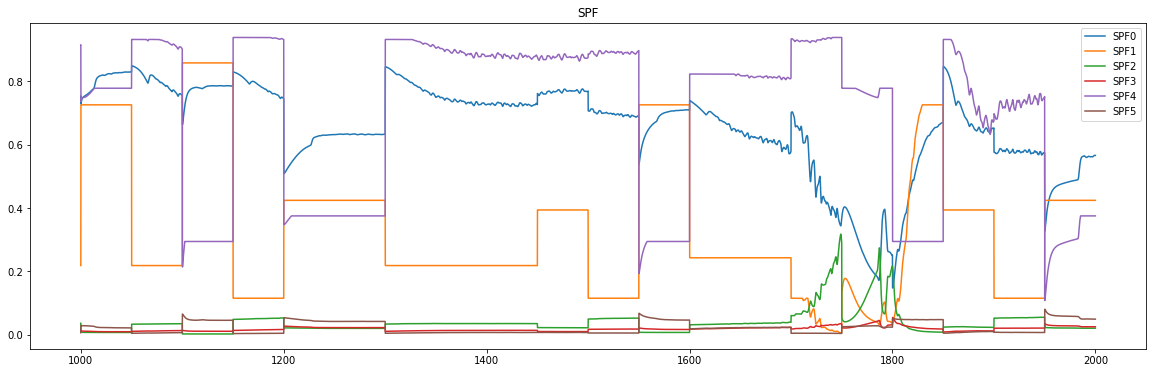

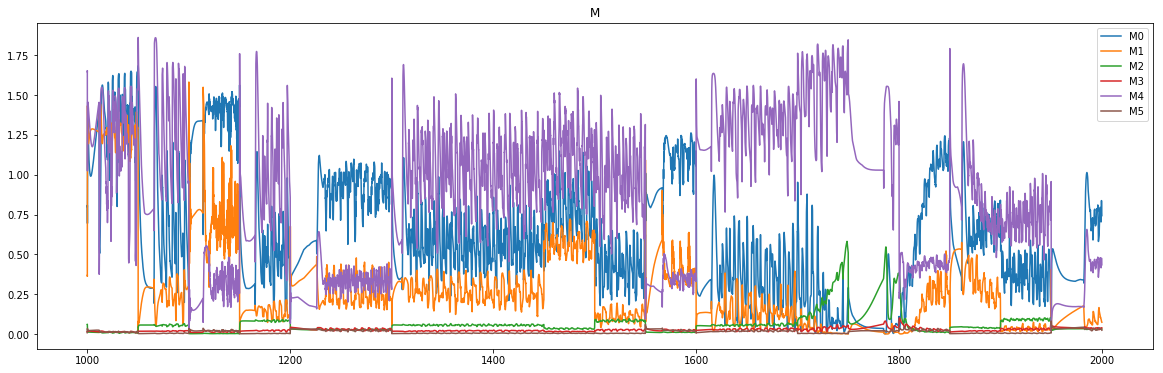

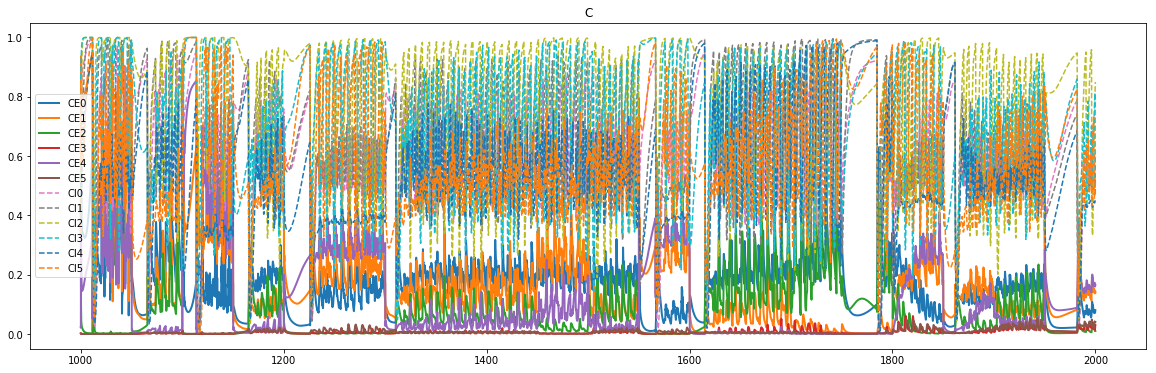

In [15]:
# plotting as in spinal_test6
pops_names = ['SF', 'SP', 'SPF', 'AL', 'AF', 'SP_CHG', 'CE', 'CI', 'M', 'ACT']
for name in pops_names:
    exec("%s = %s"% (name, str(pops_dict[name])))
arm_activs = plant_data[0]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

Text(0.5, 1.0, 'double pendulum state variables')

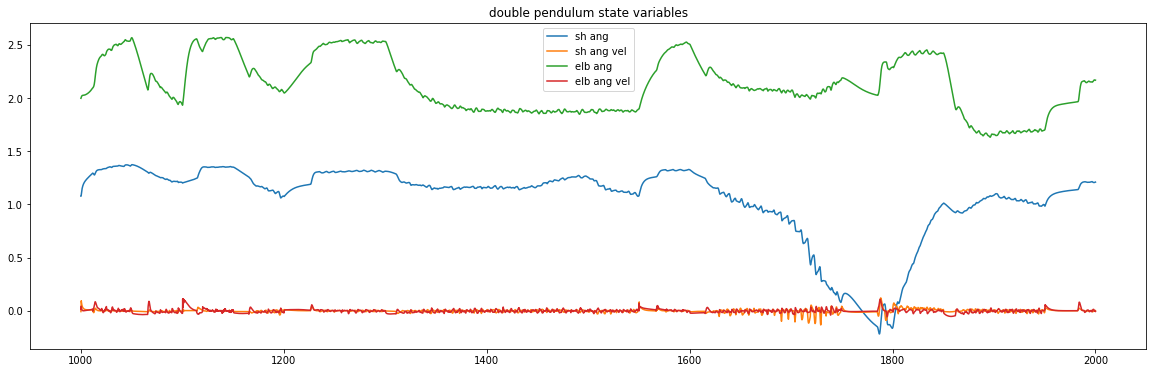

In [16]:
# P
P = 0
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4]
plt.plot(times, P_state)
plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.title('double pendulum state variables')

In [14]:
start_time = time.time()
times, data, plant_data  = net.flat_run(1000.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)

Execution time is 2832.2633969783783 seconds
